<a href="https://colab.research.google.com/github/RagaaM/Scriba/blob/main/EfficientNet_PreTrained_acc_97.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# m --> my comment
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install torchsummary
!pip install efficientnet_pytorch
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
from sklearn import metrics
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import pandas as pd
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import cv2
import os
import torchvision
import shutil
from torch.autograd import Variable
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.models as models
from torchsummary import summary
from efficientnet_pytorch import EfficientNet
import torch.optim as optim
from tqdm.autonotebook import tqdm

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=6ccb3b37acc4fa689fd4aba32d4b11855225fd9e3d1b9c594708f56b0ad5287b
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [3]:
#parameters
batch_size = 50
im_size = 150

In [4]:
train_set = '/content/drive/MyDrive/SCRIBA/Dataset-Ragaa/data/train'
test_set = '/content/drive/MyDrive/SCRIBA/Dataset-Ragaa/data/test'
print(test_set)

/content/drive/MyDrive/SCRIBA/Dataset-Ragaa/data/test


In [5]:
def normalization_parameter(dataloader):
    mean = 0.
    std = 0.
    nb_samples = len(dataloader.dataset)
    for data,_ in tqdm(dataloader):
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
    mean /= nb_samples
    std /= nb_samples
    return mean.numpy(),std.numpy()
im_size = 150

train_transforms = transforms.Compose([
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor()])
train_data = torchvision.datasets.ImageFolder(root = train_set , transform = train_transforms)
train_loader =  DataLoader(train_data, batch_size = batch_size , shuffle = True)

mean,std = normalization_parameter(train_loader)

  0%|          | 0/30 [00:00<?, ?it/s]

In [6]:
train_transforms = transforms.Compose([
                                        transforms.Resize((im_size,im_size)),
                                        transforms.RandomResizedCrop(size=315, scale=(0.95, 1.0)),
                                        transforms.RandomRotation(degrees=10),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.CenterCrop(size=299),  # Image net standards
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])
test_transforms = transforms.Compose([
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])

#inverse normalization for image plot
inv_normalize =  transforms.Normalize(
    mean=-1*np.divide(mean,std),
    std=1/std
)

In [7]:
def data_loader(train_data,test_data = None , valid_size = None , batch_size = 32):
    train_loader =  DataLoader(train_data, batch_size = batch_size , shuffle = True)
    if(test_data == None and valid_size == None):
        dataloaders = {'train':train_loader}
        return dataloaders
    if(test_data == None and valid_size!=None):
        data_len = len(train_data)
        indices = list(range(data_len))
        np.random.shuffle(indices)
        split1 = int(np.floor(valid_size * data_len))
        valid_idx , test_idx = indices[:split1], indices[split1:]
        valid_sampler = SubsetRandomSampler(valid_idx)
        valid_loader = DataLoader(train_data, batch_size= batch_size, sampler=valid_sampler)
        dataloaders = {'train':train_loader,'val':valid_loader}
        return dataloaders
    if(test_data != None and valid_size!=None):
        data_len = len(test_data)
        indices = list(range(data_len))
        np.random.shuffle(indices)
        split1 = int(np.floor(valid_size * data_len))
        valid_idx , test_idx = indices[:split1], indices[split1:]
        valid_sampler = SubsetRandomSampler(valid_idx)
        test_sampler = SubsetRandomSampler(test_idx)
        valid_loader = DataLoader(test_data, batch_size= batch_size, sampler=valid_sampler)
        test_loader = DataLoader(test_data, batch_size= batch_size, sampler=test_sampler)
        dataloaders = {'train':train_loader,'val':valid_loader,'test':test_loader}
        return dataloaders

In [8]:
#data loader
train_data = torchvision.datasets.ImageFolder(root = train_set, transform = train_transforms)  #uncommented
test_data = torchvision.datasets.ImageFolder(root = test_set, transform = test_transforms)
dataloaders = data_loader(train_data,test_data , valid_size = 0.2 , batch_size = batch_size)
print(dataloaders)
#label of classes
classes = train_data.classes
print(classes)
#encoder and decoder to convert classes into integer
decoder = {}
for i in range(len(classes)):
    decoder[classes[i]] = i
encoder = {}
for i in range(len(classes)):
    encoder[i] = classes[i]
print(dataloaders.keys())

{'train': <torch.utils.data.dataloader.DataLoader object at 0x7fafb8ac6e50>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7faeaee21350>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7faeaee212d0>}
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
dict_keys(['train', 'val', 'test'])


In [9]:
# from imutils import paths

# LABELS = set(classes)
# print("[INFO] loading images...")
# imagePaths = list(paths.list_images(train_set))
# data = []
# labels = []
# print(LABELS)

In [10]:
# for imagePath in imagePaths:
#     #extract the class label from the filename
#     label = imagePath.split(os.path.sep)[-2]
    
#     #If the label of the current image is not part of the LABELS set
#     #then ignore the image     
#     if label not in LABELS:
#         continue
#     # load the image, swap color channels, and resize it to be a fixed
#     # 224x224 pixels while ignoring aspect ratio
#     image = cv2.imread(imagePath)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     image = cv2.resize(image, (224, 224))   
#     gaussian_blur = cv2.GaussianBlur(image, (5,5), 1.5)
#     ret, thresh = cv2.threshold(gaussian_blur, 0, 255, cv2.THRESH_BINARY_INV + 
#                                             cv2.THRESH_OTSU)  
#     # plt.imshow(thresh, cmap='gray')
#     # plt.axis('off')
#     plt.show()
#      # update the data and labels lists, respectively
#     data.append(thresh)
#     labels.append(label)
#     # print(labels)


<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


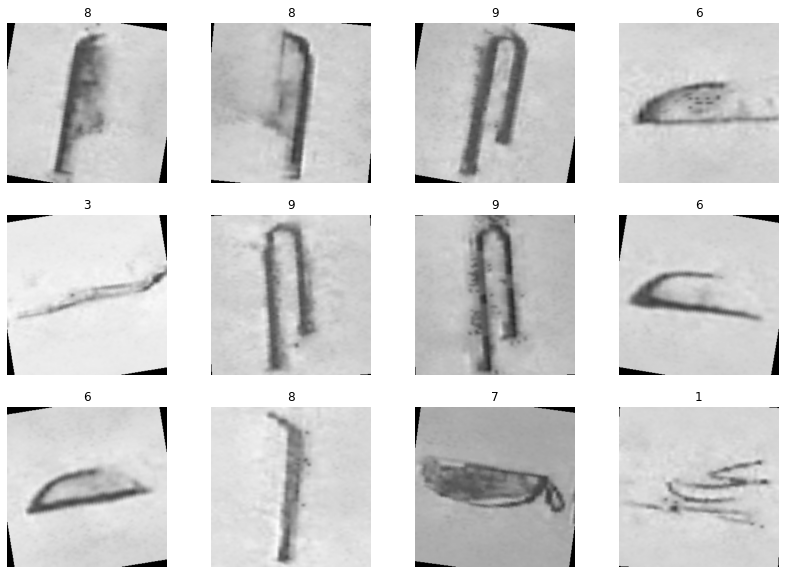

In [11]:
import matplotlib.pyplot as plt
import random
#plotting rondom images from dataset
def class_plot(data , encoder ,inv_normalize = None,n_figures = 12):
    n_row = int(n_figures/4)
    fig,axes = plt.subplots(figsize=(14, 10), nrows = n_row, ncols=4)
    for ax in axes.flatten():
        a = random.randint(0,len(data))
        (image,label) = data[a]
        print(type(image))
        label = int(label)
        l = encoder[label]
        if(inv_normalize!=None):
            image = inv_normalize(image)
        
        image = image.numpy().transpose(1,2,0)
        im = ax.imshow(image)
        ax.set_title(l)
        ax.axis('off')
    plt.show()
class_plot(train_data,encoder,inv_normalize)

In [12]:
#using efficientnet model based transfer learning (Pre-Trained)
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.resnet =  EfficientNet.from_pretrained('efficientnet-b0')
        self.l1 = nn.Linear(1000 , 256)
        self.dropout = nn.Dropout(0.75)
        self.l2 = nn.Linear(256,11)    #modify 6 --> 10  (in pytorch it has to be numofclasses+1 (stackoverflow answer)) (num of classes)
        self.relu = nn.ReLU()

    def forward(self, input):
        x = self.resnet(input)
        x = x.view(x.size(0),-1)
        x = self.dropout(self.relu(self.l1(x)))
        x = self.l2(x)
        return x

torch.cuda.empty_cache()   # just when use GPU to pervent any GPUs errors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
classifier = Classifier().to(device)

cuda


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b0


In [13]:
# # EfficientNet from scratch
# import torch.nn as nn
# from math import ceil

In [14]:
# base_model = [
#            #efficientnet-B0 baseline network (from paper)  
#            [1,16,1,1,3],
#            [6,24,2,2,3],
#            [6,40,2,2,5],
#            [6,80,3,2,3],
#            [6,112,3,1,5],
#            [6,192,4,2,5],
#            [6,320,1,1,3],          
# ]

# phi_value = {
#              #tuple of: (phi_value,resolution,drop_rate)
#              "b0": (0, 224, 0.2), #alpha(Depth),beta(Width),gamma(Resolution), depth = alpha **phi
#              "b1": (0.5, 240, 0.2),
#              "b2": (1, 260, 0.3),
#              "b3": (2, 300, 0.3),
#              "b4": (3, 380, 0.4),
#              "b5": (4, 456, 0.4),
#              "b6": (5, 528, 0.5),
#              "b7": (5, 600, 0.5),
# }

In [15]:
# class CNNBlock(nn.Module):
#   def __init__(
#       self,in_channels, out_channels, kernel_size, stride, padding, groups = 1
#   ):
#     super(CNNBlock,self).__init__()
#     self.cnn = nn.Conv2d(
#         in_channels,
#         out_channels, 
#         kernel_size, 
#         stride, 
#         padding,
#         groups = groups,
#         bias = False,
#     )
#     self.bn = nn.BatchNorm2d(out_channels)
#     self.silu = nn.SiLU() 
    
#   def forward(self,x):
#     return self.silu(self.bn(self.cnn(x)))

In [16]:
# class SqueezeExcitation(nn.Module):
#   def __init__(self,in_channels,reduced_dim):
#       super(SqueezeExcitation).__init__()
#       self.se = nn.Sequential(
#           nn.AdaptiveAvgPool2d(1),
#           nn.Conv2d(in_channels,reduced_dim, 1 ),
#           nn.SiLU(),
#           nn.Conv2d(reduced_dim,in_channels, 1),
#           nn.Sigmoid(),
#       )
      
#   def forward(self,x):
#       return x * self.se(x)

In [17]:
# class InvertedResidualBlock(nn.Module):
#   def __init__(
#       self,
#       in_channels,
#       out_channels,
#       kernel_size,
#       stride,
#       padding,
#       expand_ratio,
#       reduction=4,  #squeeze excitation
#       survival_prob = 0.8, #for stochastic depth
#   ):
#     super(InvertedResidualBlock,self).__init__()  
#     self.survival_prob = 0.8
#     self.user_residual = in_channels == out_channels and stride ==1
#     hidden_dim = in_channels * expand_ratio
#     self.expand = in_channels != hidden_dim
#     reduced_dim = int(in_channels /reduction)

#     if self.expand:
#       self.expand_conv = CNNBlock(
#           in_channels, hidden_dim, kernel_size = 3, stride =1, padding = 1,
#       )
#     self.conv = nn.Sequential(
#         CNNBlock(
#             hidden_dim, hidden_dim,kernel_size, stride,padding,groups=hidden_dim,
#         ),
#         SqueezeExcitation(hidden_dim, reduced_dim),
#         nn.Conv2d(hidden_dim, out_channels, 1, bias = False),
#         nn.BatchNorm2d(out_channels),
#     )
#   def stochastic_depth(self,x):
#     if not self.training:
#             return x

#     binary_tensor = torch.rand(x.shape[0], 1, 1, 1, device=x.device) < self.survival_prob
#     return torch.div(x, self.survival_prob) * binary_tensor

#   def forward(self, inputs):
#       x = self.expand_conv(inputs) if self.expand else inputs

#       if self.use_residual:
#           return self.stochastic_depth(self.conv(x)) + inputs
#       else:
#           return self.conv(x)


In [18]:
# class EfficientNet(nn.Module):
#   def __init__(self, version, num_classes):
#         super(EfficientNet, self).__init__()
#         width_factor, depth_factor, dropout_rate = self.calculate_factors(version)
#         last_channels = ceil(1280 * width_factor)
#         self.pool = nn.AdaptiveAvgPool2d(1)
#         self.features = self.create_features(width_factor, depth_factor, last_channels)
#         self.classifier = nn.Sequential(
#             nn.Dropout(dropout_rate),
#             nn.Linear(last_channels, num_classes),
#         )

#   def calculate_factors(self, version, alpha=1.2, beta=1.1):
#       phi, res, drop_rate = phi_value[version]
#       depth_factor = alpha ** phi
#       width_factor = beta ** phi
#       return width_factor, depth_factor, drop_rate

#   def create_features(self, width_factor, depth_factor, last_channels):
#       channels = int(32 * width_factor)
#       features = [CNNBlock(3, channels, 3, stride=2, padding=1)]
#       in_channels = channels

#       for expand_ratio, channels, repeats, stride, kernel_size in base_model:
#           out_channels = 4*ceil(int(channels*width_factor) / 4)
#           layers_repeats = ceil(repeats * depth_factor)

#           for layer in range(layers_repeats):
#               features.append(
#                   InvertedResidualBlock(
#                       in_channels,
#                       out_channels,
#                       expand_ratio=expand_ratio,
#                       stride = stride if layer == 0 else 1,
#                       kernel_size=kernel_size,
#                       padding=kernel_size//2, # if k=1:pad=0, k=3:pad=1, k=5:pad=2
#                   )
#               )
#               in_channels = out_channels

#       features.append(
#           CNNBlock(in_channels, last_channels, kernel_size=1, stride=1, padding=0)
#       )

#       return nn.Sequential(*features)

#   def forward(self, x):
#       x = self.pool(self.features(x))
#       return self.classifier(x.view(x.shape[0], -1))

In [19]:
# # torch.cuda.empty_cache()   # just when use GPU to pervent any GPUs errors
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# # print(device)
# # classifier = Classifier().to(device)
# version = "b0"
# phi, res, drop_rate = phi_value[version]
# num_examples, num_classes = 1000, 10
# classifier_fromScratch = EfficientNet(
#     version=version,
#     num_classes=num_classes,
# ).to(device)

In [20]:
criterion = nn.CrossEntropyLoss()

In [21]:
import numpy as np
import torch
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

In [22]:
def train(model,dataloaders,criterion,num_epochs=10,lr=0.00001,batch_size=8,patience = None):
    since = time.time()
    model.to(device)
    best_acc = 0.0
    i = 0
    phase1 = dataloaders.keys()
    losses = list()
    acc = list()
    if(patience!=None):
        earlystop = EarlyStopping(patience = patience,verbose = True)   # if loss improved
    for epoch in range(num_epochs):
        print('Epoch:',epoch)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        lr = lr*0.8
        if(epoch%10==0):
            lr = 0.0001

        for phase in phase1:
            if phase == ' train':
                model.train()
            else:    # test and val
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            total = 0
            j = 0
            for  batch_idx, (data, target) in enumerate(dataloaders[phase]):
                data, target = Variable(data), Variable(target)
                data = data.type(torch.cuda.FloatTensor)   # use cpu instead of gpu
                target = target.type(torch.cuda.LongTensor)
                optimizer.zero_grad()  #This will in general have lower memory footprint, and can modestly improve performance instead of giving zero value.
                output = model(data)
                # print(data)
                # print(output.shape)   # el mafrod yetla3 [batch_size,num_of_classes]   --> tale3ly [100,6]   6 el mafrod tkon 10
                # print(target)
                # print(target-1)
                # print("target :",target.data)
                # print("minimum:", min(target))
                # print("maximum:", max(target))
                loss = criterion(output, target)  # hn-check hena
                _, preds = torch.max(output, 1)
                running_corrects = running_corrects + torch.sum(preds == target.data)
                running_loss += loss.item() * data.size(0)
                j = j+1
                if(phase =='train'):
                    loss.backward()
                    optimizer.step()

                if batch_idx % 300 == 0:
                    print('{} Epoch: {}  [{}/{} ({:.0f}%)]\tLoss: {:.6f} \tAcc: {:.6f}'.format(phase,epoch, batch_idx * len(data), len(dataloaders[phase].dataset),100. * batch_idx / len(dataloaders[phase])
                                                                                                 , running_loss/(j*batch_size),running_corrects.double()/(j*batch_size)))
            epoch_acc = running_corrects.double()/(len(dataloaders[phase])*batch_size)
            epoch_loss = running_loss/(len(dataloaders[phase])*batch_size)
            if(phase == 'val'):
                earlystop(epoch_loss,model)

            if(phase == 'train'):
                losses.append(epoch_loss)
                acc.append(epoch_acc)
            print(earlystop.early_stop)
        if(earlystop.early_stop):
            print("Early stopping")
            model.load_state_dict(torch.load('./checkpoint.pt'))
            break
        print('{} Accuracy: '.format(phase),epoch_acc.item())
    return losses,acc

In [23]:
def test(dataloader):
    running_corrects = 0
    running_loss=0
    pred = []
    true = []
    pred_wrong = []
    true_wrong = []
    image = []
    sm = nn.Softmax(dim = 1)
    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = Variable(data), Variable(target)
        data = data.type(torch.cuda.FloatTensor)   # change torch.cuda.FloatTensor --> torch.FloatTensor
        target = target.type(torch.cuda.LongTensor)   # change torch.cuda.LongTensor --> torch,LongTensor   (CPU instead of GPU)
        classifier.eval()
        output = classifier(data)
        loss = criterion(output, target)
        output = sm(output)
        _, preds = torch.max(output, 1)
        running_corrects = running_corrects + torch.sum(preds == target.data)
        running_loss += loss.item() * data.size(0)
        preds = preds.cpu().numpy()
        target = target.cpu().numpy()
        preds = np.reshape(preds,(len(preds),1))
        target = np.reshape(target,(len(preds),1))
        data = data.cpu().numpy()
        
        for i in range(len(preds)):
            pred.append(preds[i])
            true.append(target[i])
            if(preds[i]!=target[i]):
                pred_wrong.append(preds[i])
                true_wrong.append(target[i])
                image.append(data[i])
      
    epoch_acc = running_corrects.double()/(len(dataloader)*batch_size)
    epoch_loss = running_loss/(len(dataloader)*batch_size)
    print(epoch_acc,epoch_loss)
    return true,pred,image,true_wrong,pred_wrong

In [24]:
def error_plot(loss):
    plt.figure(figsize=(10,5))
    plt.plot(loss)
    plt.title("Training loss plot")
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.show()
def acc_plot(acc):
    plt.figure(figsize=(10,5))
    plt.plot(acc)
    plt.title("Training accuracy plot")
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.show()

# To plot the wrong predictions given by model
def wrong_plot(n_figures,true,ima,pred,encoder,inv_normalize):
    print('Classes in order Actual and Predicted')
    n_row = int(n_figures/3)
    fig,axes = plt.subplots(figsize=(14, 10), nrows = n_row, ncols=3)
    for ax in axes.flatten():
        a = random.randint(0,len(true)-1)
    
        image,correct,wrong = ima[a],true[a],pred[a]
        image = torch.from_numpy(image)
        correct = int(correct)
        c = encoder[correct]
        wrong = int(wrong)
        w = encoder[wrong]
        f = 'A:'+c + ',' +'P:'+w
        if inv_normalize !=None:
            image = inv_normalize(image)
        image = image.numpy().transpose(1,2,0)
        im = ax.imshow(image)
        ax.set_title(f)
        ax.axis('off')
    plt.show()
    
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
def performance_matrix(true,pred):
    precision = metrics.precision_score(true,pred,average='macro')
    recall = metrics.recall_score(true,pred,average='macro')
    accuracy = metrics.accuracy_score(true,pred)
    f1_score = metrics.f1_score(true,pred,average='macro')
    print('Precision: {} Recall: {}, Accuracy: {}: ,f1_score: {}'.format(precision*100,recall*100,accuracy*100,f1_score*100))

In [25]:
def train_model(model,dataloaders,criterion,num_epochs,lr=0.0001,batch_size=8,patience = None,classes = None):
    dataloader_train = {}
    losses = list()
    accuracy = list()
    key = dataloaders.keys()
    for phase in key:
        if(phase == 'test'):
            perform_test = True
        else:
            dataloader_train.update([(phase,dataloaders[phase])])
    losses,accuracy = train(model,dataloader_train,criterion,num_epochs,lr,batch_size,patience)
    error_plot(losses)
    acc_plot(accuracy)
    if(perform_test == True):
        true,pred,image,true_wrong,pred_wrong = test(dataloaders['test'])
        wrong_plot(12,true_wrong,image,pred_wrong,encoder,inv_normalize)
        performance_matrix(true,pred)
        if(classes !=None):
            plot_confusion_matrix(true, pred, classes= classes,title='Confusion matrix, without normalization')

Epoch: 0
train Epoch: 0  [0/1453 (0%)]	Loss: 2.424737 	Acc: 0.000000
False
val Epoch: 0  [0/200 (0%)]	Loss: 0.260128 	Acc: 0.660000
Validation loss decreased (inf --> 0.260128).  Saving model ...
False
val Accuracy:  0.66
Epoch: 1
train Epoch: 1  [0/1453 (0%)]	Loss: 0.172833 	Acc: 0.940000
False
val Epoch: 1  [0/200 (0%)]	Loss: 0.134727 	Acc: 0.760000
Validation loss decreased (0.260128 --> 0.134727).  Saving model ...
False
val Accuracy:  0.76
Epoch: 2
train Epoch: 2  [0/1453 (0%)]	Loss: 0.024571 	Acc: 1.000000
False
val Epoch: 2  [0/200 (0%)]	Loss: 0.065957 	Acc: 0.780000
Validation loss decreased (0.134727 --> 0.065957).  Saving model ...
False
val Accuracy:  0.78
Epoch: 3
train Epoch: 3  [0/1453 (0%)]	Loss: 0.042987 	Acc: 1.000000
False
val Epoch: 3  [0/200 (0%)]	Loss: 0.063267 	Acc: 0.780000
Validation loss decreased (0.065957 --> 0.063267).  Saving model ...
False
val Accuracy:  0.78
Epoch: 4
train Epoch: 4  [0/1453 (0%)]	Loss: 0.013767 	Acc: 1.000000
False
val Epoch: 4  [0/200 (

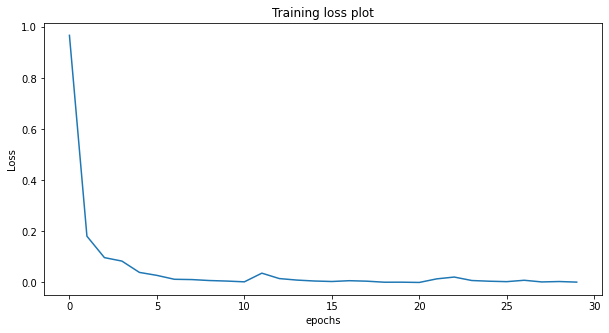

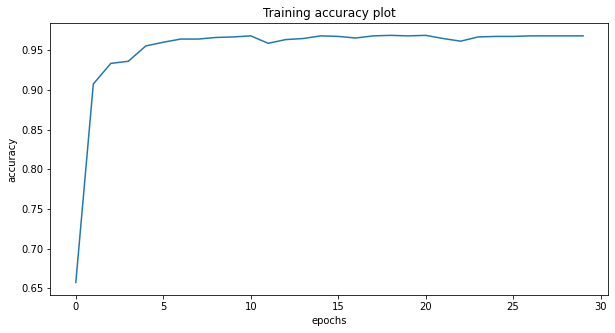

tensor(0.7800, device='cuda:0', dtype=torch.float64) 0.0774291498833918
Classes in order Actual and Predicted


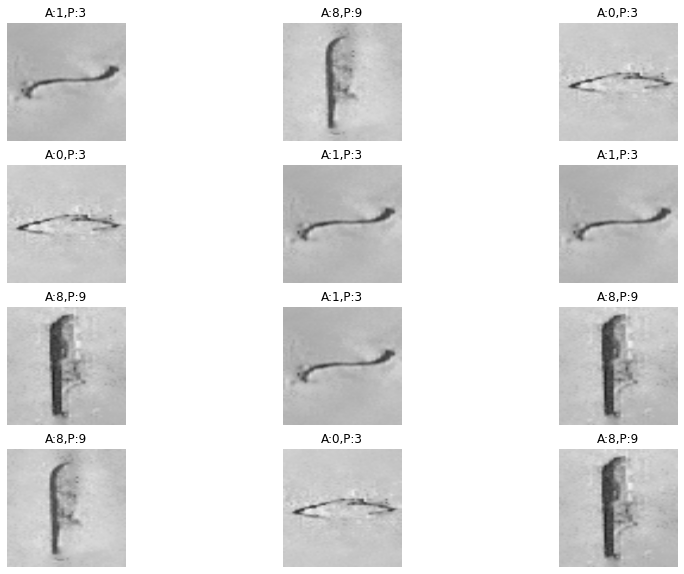

Precision: 97.66666666666669 Recall: 97.61029411764707, Accuracy: 97.5: ,f1_score: 97.50878754804901
Confusion matrix, without normalization
[[16  0  0  1  0  0  0  0  0  0]
 [ 0 15  0  1  0  0  0  0  0  0]
 [ 0  0 13  0  0  0  0  0  0  0]
 [ 0  0  0 18  0  0  0  0  0  0]
 [ 0  0  0  0 16  0  0  0  0  0]
 [ 0  0  0  0  0 17  0  0  0  0]
 [ 0  0  0  0  0  0 16  0  0  0]
 [ 0  0  0  0  0  0  0 17  0  0]
 [ 0  0  0  0  0  0  0  0 15  2]
 [ 0  0  0  0  0  0  0  0  0 13]]


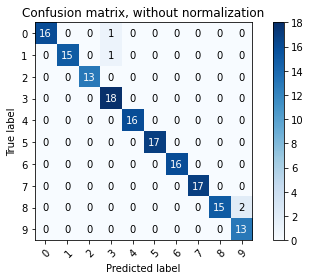

In [26]:
train_model(classifier,dataloaders,criterion,30, patience = 30 , batch_size = batch_size , classes = classes)

In [27]:
#Predict
from PIL import Image
import numpy as np
import cv2
def predict(model,image,device,encoder,transforms = None,inv_normalize = None):
    #model = torch.load('./model.h5')
    model.eval()
    if(isinstance(image,np.ndarray)):
      image = Image.fromarray(image)
    if(transforms!=None):
        image = transforms(image)
    data = image.expand(1,-1,-1,-1)
    data = data.type(torch.FloatTensor).to(device)
    sm = nn.Softmax(dim = 1)
    output = model(data)
    output = sm(output)
    _, preds = torch.max(output, 1)
    img_plot(image,inv_normalize)
    prediction_bar(output,encoder)
    return preds
def prediction_bar(output,encoder):
    output = output.cpu().detach().numpy()
    a = output.argsort()
    a = a[0]
    
    size = len(a)
    if(size>5):
        a = np.flip(a[-5:])
    else:
        a = np.flip(a[-1*size:])
    prediction = list()
    clas = list()
    for i in a:
      prediction.append(float(output[:,i]*100))
      clas.append(str(i))
    for i in a:
        print('Class: {} , confidence: {}'.format(encoder[int(i)],float(output[:,i]*100)))
    plt.bar(clas,prediction)
    plt.title("Confidence score bar graph")
    plt.xlabel("Confidence score")
    plt.ylabel("Class number")
 
def img_plot(image,inv_normalize = None):
    if(inv_normalize!=None):
        image = inv_normalize(image)
    image = image.cpu().numpy().transpose(1,2,0)
    plt.imshow(image)
    plt.show()

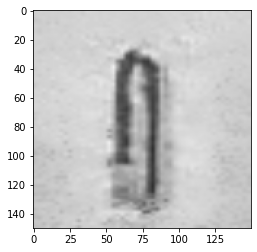

Class: 9 , confidence: 99.99998474121094
Class: 8 , confidence: 1.4986190763011109e-05
Class: 1 , confidence: 3.2783411825221265e-06
Class: 2 , confidence: 8.372522870558896e-07
Class: 3 , confidence: 1.565669833780703e-07


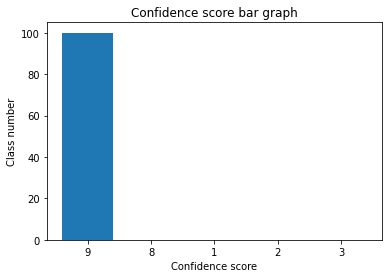

In [28]:
image = cv2.imread('/content/drive/MyDrive/SCRIBA/Dataset-Ragaa/data/test/9/200031_S29.png')
pred = predict(classifier,image,device,encoder,test_transforms,inv_normalize)